In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print(f'Available device: {device}')

Available device: cpu


In [ ]:
training_csv_path = 'B. Disease Grading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
testing_csv_path = 'B. Disease Grading/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'
root_disease_grading_path = 'B. Disease Grading/B. Disease Grading/'

training_images_path = 'B. Disease Grading/B. Disease Grading/1. Original Images/a. Training Set/'
testing_images_path = 'B. Disease Grading/B. Disease Grading/1. Original Images/b. Testing Set/'

In [ ]:
class RetinalImageDataset(Dataset):
    def __init__(self, csv_df, images_path, transform=None, num_samples=None):
        """
        Args:
            csv_df (string): Dataframe from the csv file containing the data set
            transform (callable, optional): Optional transform to be applied on a sample
            num_samples (int, optional): Number of samples to load. If None, loads all samples
            images_path (string): Path to image set
        """
        self.csv_file = csv_df
        if num_samples is not None:
            self.csv_file = self.csv_file.head(num_samples)
        self.transform = transform
        self.images_path = images_path

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        # Get image path and label
        img_path = self.images_path + self.csv_file.iloc[index, 0] + '.jpg'
        label = self.csv_file.iloc[index, 1]
        #print(f'Path: {img_path}, Label: {label}')

        # Load and convert the image
        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Convert label to float
        label = torch.tensor(label, dtype=torch.float)

        return image, label

In [ ]:
# Data Cleaning
training_csvfile = pd.read_csv(training_csv_path)
unnamed_columns = training_csvfile.columns[training_csvfile.columns.str.contains('Unnamed', case=False)]
training_csvfile = training_csvfile.drop(columns=unnamed_columns)

drop_columns = ['Retinopathy grade', 'Risk of macular edema ']

training_csvfile['Has Retinopathy'] = (training_csvfile['Retinopathy grade'] > 0).astype(int)
training_csvfile = training_csvfile.drop(columns=drop_columns)

testing_csvfile = pd.read_csv(testing_csv_path)
testing_csvfile['Has Retinopathy'] = (testing_csvfile['Retinopathy grade'] > 0).astype(int)
testing_csvfile = testing_csvfile.drop(columns=drop_columns)

print('Training\n', training_csvfile[185:195])
print('\nTesting\n',testing_csvfile[35:45])

Training
     Image name  Has Retinopathy
185  IDRiD_186                1
186  IDRiD_187                1
187  IDRiD_188                1
188  IDRiD_189                1
189  IDRiD_190                0
190  IDRiD_191                1
191  IDRiD_192                1
192  IDRiD_193                0
193  IDRiD_194                1
194  IDRiD_195                0

Testing
    Image name  Has Retinopathy
35  IDRiD_036                1
36  IDRiD_037                0
37  IDRiD_038                0
38  IDRiD_039                0
39  IDRiD_040                1
40  IDRiD_041                0
41  IDRiD_042                1
42  IDRiD_043                0
43  IDRiD_044                0
44  IDRiD_045                0


In [ ]:
# Image Pre-Processing
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomPerspective(0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])   
])

val_and_testing_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])   
])

In [ ]:
# Load dataset
retinal_image_dataset = RetinalImageDataset(training_csvfile, training_images_path, transform=train_transforms)
train_size = 0.8
val_size = 0.2

train_dataset, _ = random_split(retinal_image_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

retinal_image_dataset2 = RetinalImageDataset(training_csvfile, training_images_path, transform=val_and_testing_transforms)
train_size = 0.8
val_size = 0.2

_, val_dataset = random_split(retinal_image_dataset2, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(train_dataset.indices)
print(val_dataset.indices)
print(f'Size of training indices list: {len(train_dataset.indices)}')
print(f'Size of val indices list: {len(val_dataset.indices)}')
print(f'Common elements: {list(set(train_dataset.indices) & set(val_dataset.indices))}')
            

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(f'Loading image from path: {training_images_path}')
print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(val_dataset)}')

[64, 20, 234, 257, 282, 28, 196, 411, 183, 342, 261, 363, 310, 167, 50, 335, 122, 372, 135, 71, 96, 105, 4, 154, 141, 182, 73, 106, 240, 216, 302, 407, 24, 30, 339, 357, 296, 101, 45, 367, 278, 155, 397, 412, 92, 36, 56, 237, 391, 54, 272, 1, 100, 152, 85, 25, 153, 389, 136, 41, 148, 195, 406, 173, 32, 23, 322, 93, 264, 346, 109, 224, 81, 366, 360, 300, 14, 408, 126, 51, 33, 188, 376, 236, 354, 151, 192, 191, 393, 306, 158, 242, 356, 22, 231, 82, 169, 332, 319, 323, 204, 254, 142, 248, 9, 118, 210, 198, 338, 123, 97, 387, 405, 134, 111, 348, 253, 362, 57, 395, 286, 165, 127, 98, 328, 308, 355, 235, 13, 244, 214, 295, 341, 233, 159, 133, 379, 285, 107, 58, 181, 381, 119, 262, 287, 203, 340, 303, 276, 396, 258, 271, 368, 291, 139, 77, 114, 62, 293, 43, 345, 241, 207, 74, 222, 197, 263, 229, 410, 27, 171, 385, 277, 184, 175, 69, 382, 156, 301, 160, 53, 7, 117, 213, 337, 309, 40, 299, 384, 202, 162, 313, 369, 223, 140, 220, 290, 304, 209, 305, 267, 260, 365, 48, 294, 297, 76, 37, 55, 161, 

In [ ]:
'''
# Training with a CNN model based on a proposed RSG-Net (Retinopathy Severity Grading Net) model
# From paper A deep learning based model for diabetic retinopathy grading by Samia Akhtar, Shabib Aftab, Oualid Ali, Munir Ahmad, Muhammad Adnan Khan,
SagheerAbbas & Taher M.Ghazal
'''

class RSG_Net(nn.Module):
    def __init__(self):
        super(RSG_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128 * 64 * 64, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.1)

        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x)).squeeze(1)
        return x

rsg_net_model = RSG_Net()
rsg_net_model = rsg_net_model.to(device)

In [ ]:
criterion = nn.BCELoss()
#optimizer = optim.Adam(vgg_16_cnn_model.parameters(), lr=0.0025, weight_decay=1e-4)
optimizer = optim.SGD(rsg_net_model.parameters(), lr=0.001)

In [ ]:
# Training and Validation Loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0

    # Training
    rsg_net_model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = rsg_net_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(train_dataloader))

    # Validation
    rsg_net_model.eval()
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            val_outputs = rsg_net_model(images)
            val_loss = criterion(val_outputs, labels)
            total_val_loss += val_loss.item()
        val_losses.append(total_val_loss / len(val_dataloader))
    
    # Print Epochs and loss information
    print(f'Epoch: [{epoch + 1}/{num_epochs}], Training Loss: {total_train_loss / len(train_dataloader)} , Validation Loss: {total_val_loss / len(val_dataloader)}')


Epoch: [1/5], Training Loss: 0.6598384542898699 , Validation Loss: 0.7321505943934122
Epoch: [2/5], Training Loss: 0.5853702480142767 , Validation Loss: 0.6332693696022034
Epoch: [3/5], Training Loss: 0.6000032262368635 , Validation Loss: 0.5981821417808533
Epoch: [4/5], Training Loss: 0.5407713570378043 , Validation Loss: 0.583495577176412
Epoch: [5/5], Training Loss: 0.5872099047357385 , Validation Loss: 0.5989908973375956


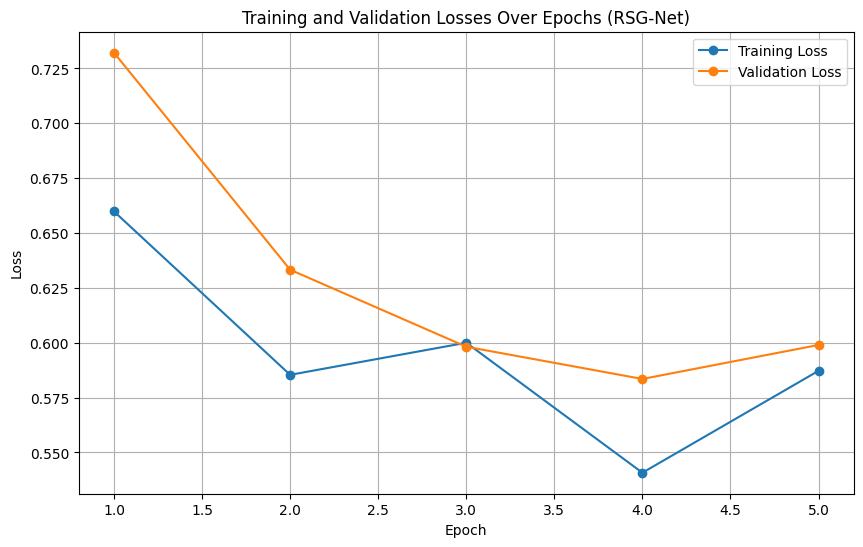

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs (RSG-Net)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Testing the model
# Load the testing data set

test_dataset = RetinalImageDataset(testing_csvfile, testing_images_path, transform=val_and_testing_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_pred_probs = []
test_pred_labels = []
test_true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = rsg_net_model(images)

        test_pred_probs.extend(outputs.cpu().numpy())

        pred_labels = torch.round(outputs)
        test_pred_labels.extend(pred_labels.cpu().numpy())

        test_true_labels.extend(labels.cpu().numpy())

test_pred_probs = np.array(test_pred_probs)
test_pred_labels = np.array(test_pred_labels)
test_true_labels = np.array(test_true_labels)

for i in range(103):
    print(f'Predicted Probablity:{test_pred_probs[i]}, Predicted Label:{test_pred_labels[i]}, Actual Label:{test_true_labels[i]}')

Predicted Probablity:0.5283547639846802, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6979634761810303, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6954777836799622, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.26288172602653503, Predicted Label:0.0, Actual Label:1.0
Predicted Probablity:0.3222239315509796, Predicted Label:0.0, Actual Label:1.0
Predicted Probablity:0.47782447934150696, Predicted Label:0.0, Actual Label:1.0
Predicted Probablity:0.6872490048408508, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.5689730644226074, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.7055525779724121, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.338213711977005, Predicted Label:0.0, Actual Label:1.0
Predicted Probablity:0.29078811407089233, Predicted Label:0.0, Actual Label:1.0
Predicted Probablity:0.6189566850662231, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6928315758705139, Predicted

In [ ]:
from sklearn.metrics import classification_report

classes = ['Does not have retinopathy', 'Has retinopathy']

report = classification_report(test_true_labels, test_pred_labels, target_names=classes)

print(report)

                           precision    recall  f1-score   support

Does not have retinopathy       0.42      0.29      0.34        34
          Has retinopathy       0.70      0.80      0.74        69

                 accuracy                           0.63       103
                macro avg       0.56      0.55      0.54       103
             weighted avg       0.60      0.63      0.61       103

